# Visualization

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import autograd.numpy as np
import matplotlib.pyplot as plt

from counterfactualgp.gp import GP
from counterfactualgp.mean import LinearWithBsplinesBasis
from counterfactualgp.treatment import DummyTreatment, Treatment
from counterfactualgp.mpp import BinaryActionModel
from counterfactualgp.cov import iid_cov, se_cov
from counterfactualgp.bsplines import BSplines

In [2]:
with open('dataset/data_set_bspline_3classes.pkl', 'rb') as fin:
    data = pickle.load(fin)

In [3]:
low, high = 0.0, 24.0
num_basis = 5
bsplines_degree = 3
n_clusters = 3
basis = BSplines(low, high, num_basis, bsplines_degree, boundaries='space')
random_basis = np.random.multivariate_normal(np.zeros(num_basis), 0.1*np.eye(num_basis), n_clusters)

In [4]:
def predict(gp, y, x, x_star):
    t, rx = x
    t_star, rx_star = x_star
    yhat, cov_hat = gp.predict((t_star, rx_star), y, (t, rx))
        
    return yhat, cov_hat

In [5]:
def draw_bsplines(basis, coef, n_classes):
    t = np.linspace(basis._low, basis._high, num=100)

    fig, axes = plt.subplots(nrows=1, ncols=n_classes, sharey=True, figsize=(4*n_classes, 4))
    for i,w in enumerate(coef):
        y = np.dot(basis.design(t), w)
        if isinstance(axes, np.ndarray): 
            axes[i].plot(t, y)
        else:
            axes.plot(t, y)

    plt.show()

In [6]:
def draw_samples(gp, samples, t_star, rx_star, nrow=3, ncol=3, title='',
                 truncated_time=None, copy_truncated_rx=False):
    
    def _concat_x(t1, rx1, t2, rx2):
        t = np.concatenate([t1, t2])
        rx = np.concatenate([rx1, rx2])
        idx = np.argsort(t)
        return t[idx], rx[idx]
    
    # reset `rx_star` if not truncated
    if truncated_time is not None:
        rx_star[t_star <= truncated_time] = 0
    else:
        rx_star = np.zeros(rx_star.shape[0])
    
    fig, axes = plt.subplots(nrow, ncol, sharex=True, figsize=(12,6), sharey=True)
    for i in range(nrow):
        for j in range(ncol):
            idx = i*nrow+j            
            y, x = samples[idx]
            t, rx = x
            
            if truncated_time is not None:
                _y = y[t <= truncated_time]
                _t = t[t <= truncated_time]
                _rx = rx[t <= truncated_time]
                if copy_truncated_rx:
                    _t_star, _rx_star = _concat_x(t, rx, t_star, rx_star)
                else:
                    _t_star, _rx_star = _concat_x(_t, _rx, t_star, rx_star)
            else:
                _y, _t, _rx = y, t, rx
                _t_star, _rx_star = _concat_x(_t, _rx, t_star, rx_star)
            
            yhat, cov_hat = predict(gp, _y, (_t, _rx), (_t_star, _rx_star))
            y_std = np.diag(cov_hat)
            
            axes[i, j].plot(_t_star, yhat, color='b')
            axes[i, j].scatter(t, y, marker='o', color='r')
            for _tt, _rx in zip(t, rx):
                if _rx == 1:
                    axes[i, j].axvline(x=_tt, color = 'y')
            axes[i, j].fill_between(_t_star, yhat - y_std, yhat + y_std,
                                 alpha=0.2, color='k')
            if truncated_time is not None:
                axes[i, j].axvline(x=truncated_time, color='r', ls='--')
    fig.suptitle(title)
    plt.show()

## Baseline GP without treatment

In [7]:
m = []
m.append(LinearWithBsplinesBasis(num_basis, bsplines_degree, (low, high), no=0))
tr = []
tr.append( (1.0, DummyTreatment()) )
bgp = GP(m, se_cov(a=1.0, l=1.0), tr, ac_fn=None)
bgp.fit(data['training2'], init = False)
print(bgp.params)

obj= 5172.093505021836
obj= 5108.271061553546
obj= 5093.58607140126
obj= 5065.668715385415
obj= 4819.282659977127
obj= 4501.581462050778
obj= 4482.47337073403
obj= 4481.9286425267865
obj= 4481.866639475447
obj= 4481.84282802141
obj= 4481.8427795390635
obj= 4481.842779060398
obj= 4481.842779049519
obj= 4481.842779049489
obj= 4481.842779049487
{'ln_cov_l_F': array([0.]), 'classes_prob_logit_F': array([1.]), 'linear_with_bsplines_basis_mean_coef0': array([-4.96327752,  1.93202105,  0.29571434,  0.18211345,  0.36652351]), 'ln_cov_a_F': array([0.]), 'ln_cov_y': array([-2.29257482])}


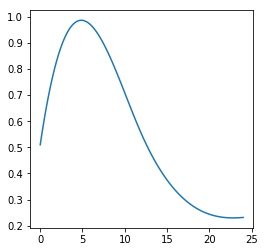

In [8]:
coef = [bgp.params['linear_with_bsplines_basis_mean_coef{}'.format(no)] for no in range(len(m))]
draw_bsplines(basis, coef, len(m))

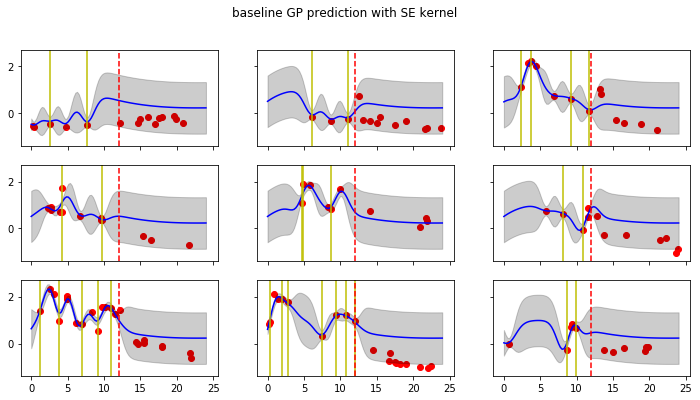

In [9]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(bgp, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'baseline GP prediction with SE kernel', data['truncated_time'])

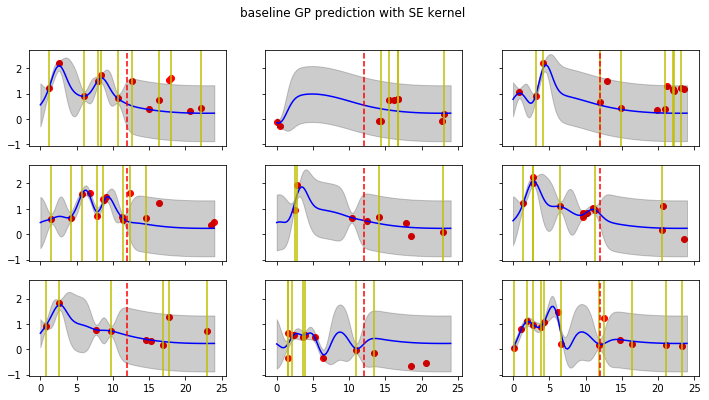

In [10]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(bgp, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'baseline GP prediction with SE kernel', 
             data['truncated_time'], copy_truncated_rx=True)

## Baseline GP with treatment

In [11]:
m = []
m.append(LinearWithBsplinesBasis(num_basis, bsplines_degree, (low, high), no=0))
tr = []
tr.append( (1.0, Treatment(2.0)) )
bgp_rx = GP(m, se_cov(a=1.0, l=1.0), tr, ac_fn=None)
bgp_rx.fit(data['training2'], init = False)
print(bgp_rx.params)

obj= 5047.184530152005
obj= 3741.3515469505464
obj= 3721.45923858432
obj= 3721.179362199496
obj= 3720.6913068132108
obj= 3716.7686175078875
obj= 3713.950377427335
obj= 3713.6823298503023
obj= 3713.6519266791415
obj= 3713.643495591339
obj= 3713.643088313293
obj= 3713.6430837186804
obj= 3713.6430836993277
obj= 3713.6430836987433
obj= 3713.643083698739
{'ln_cov_l_F': array([0.]), 'effects_window_F': array([2.]), 'treatment': array([0.53047862]), 'classes_prob_logit_F': array([1.]), 'linear_with_bsplines_basis_mean_coef0': array([-1.63212877,  1.1783987 ,  0.12595539, -0.13996613, -0.12918574]), 'ln_cov_y': array([-2.94221228]), 'ln_cov_a_F': array([0.])}


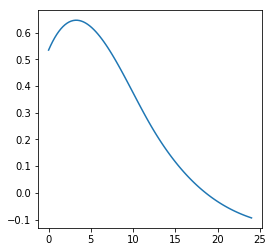

In [12]:
coef = [bgp_rx.params['linear_with_bsplines_basis_mean_coef{}'.format(no)] for no in range(len(m))]
draw_bsplines(basis, coef, len(m))

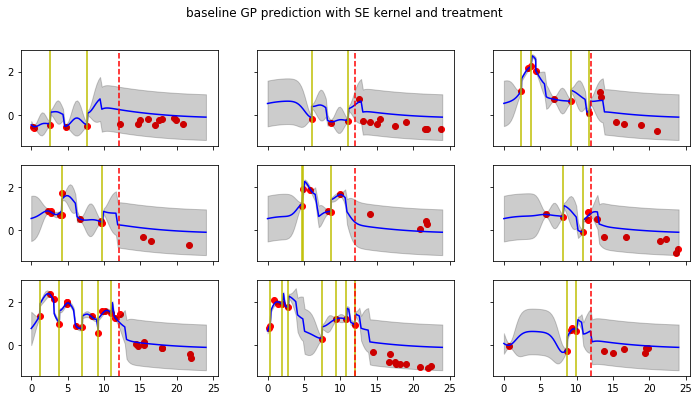

In [13]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(bgp_rx, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'])

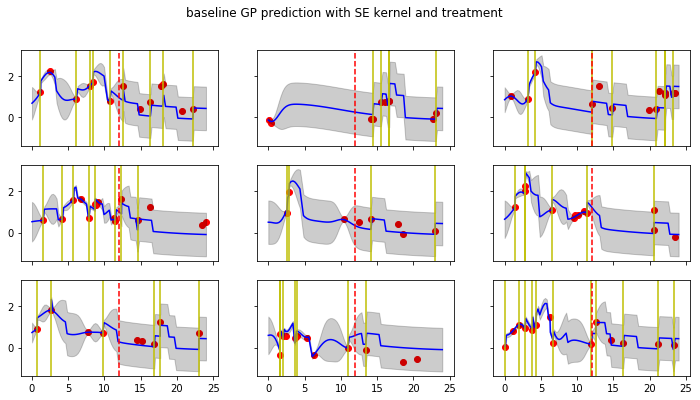

In [14]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(bgp_rx, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'], copy_truncated_rx=True)

## Counterfactual GP

In [15]:
m = []
m.append(LinearWithBsplinesBasis(num_basis, bsplines_degree, (low, high), no=0))
tr = []
tr.append( (0.0, DummyTreatment()) )
tr.append( (1.0, Treatment(2.0)) )
ac = BinaryActionModel()
cgp = GP(m, se_cov(a=1.0, l=1.0), tr, ac_fn=ac)
cgp.fit(data['training2'], init = False)
print(cgp.params)

obj= [8060.46203138]
obj= [7488.38676326]
obj= [7356.48734348]
obj= [7334.35313593]
obj= [7319.74188348]
obj= [7198.81605311]
obj= [7014.42477714]
obj= [6872.83344874]
obj= [6870.78892778]
obj= [6870.61760698]
obj= [6870.58081517]
obj= [6870.57352752]
obj= [6870.57347566]
obj= [6870.57347518]
obj= [6870.57347516]
obj= [6870.57347516]
{'ln_cov_l_F': array([0.]), 'ln_cov_a_F': array([0.]), 'linear_with_bsplines_basis_mean_coef0': array([-2.11545859,  1.28354713,  0.11735672, -0.08626169, -0.36879375]), 'effects_window_F': array([2.]), 'treatment': array([0.60686055]), 'action': array([0.35276248]), 'classes_prob_logit_F': array([1.]), 'ln_cov_y': array([-3.06457102])}


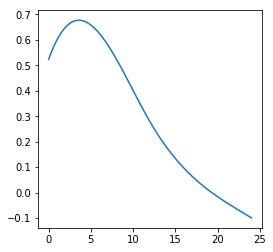

In [16]:
coef = [cgp.params['linear_with_bsplines_basis_mean_coef{}'.format(no)] for no in range(len(m))]
draw_bsplines(basis, coef, len(m))

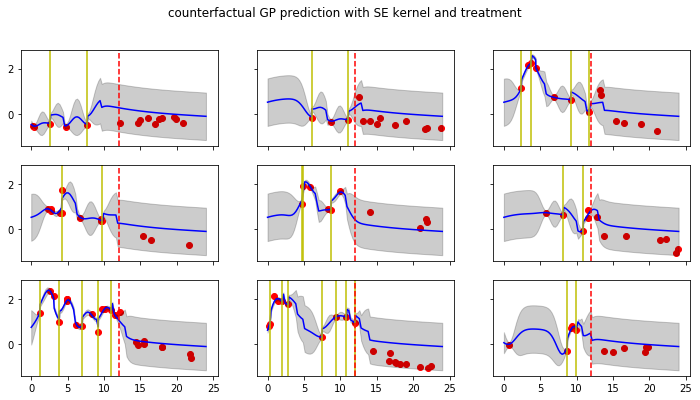

In [17]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(cgp, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'counterfactual GP prediction with SE kernel and treatment', 
             data['truncated_time'])

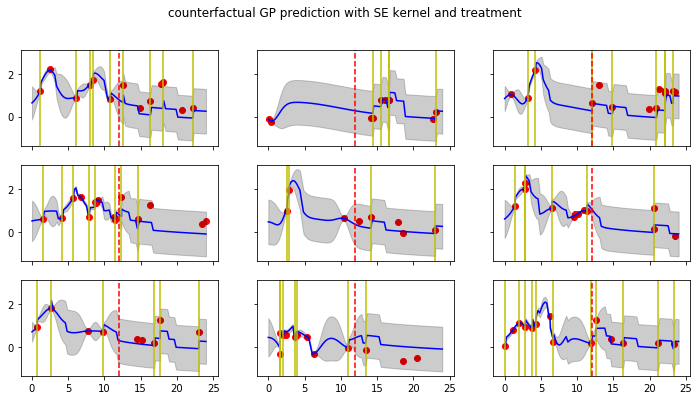

In [18]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(cgp, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'counterfactual GP prediction with SE kernel and treatment', 
             data['truncated_time'], copy_truncated_rx=True)

## Mixture of BGPs without treatment

obj= 5441.775057549435
obj= 5126.75003503953
obj= 4769.768860655679
obj= 4705.5610816831
obj= 4679.03500568447
obj= 4628.636959025325
obj= 4552.4442062454955
obj= 4515.253544285351
obj= 4493.750832844661
obj= 4484.886084110938
obj= 4483.14548082172
obj= 4482.917578221252
obj= 4482.638395016318
obj= 4482.449787484013
obj= 4482.257523885829
obj= 4482.09964113985
obj= 4481.999262296556
obj= 4481.956171346766
obj= 4481.931738800037
obj= 4481.906557064733
obj= 4481.881931556985
obj= 4481.865520635845
obj= 4481.856589860985
obj= 4481.85070640235
obj= 4481.846669286961
obj= 4481.844617311202
obj= 4481.843768974516
obj= 4481.843331125107
obj= 4481.843053318153
obj= 4481.84290786635
obj= 4481.842846568115
obj= 4481.8428164418165
obj= 4481.842797917847
obj= 4481.84278795347
obj= 4481.84278362938
obj= 4481.842781556788
obj= 4481.842780325276
obj= 4481.84277965595
obj= 4481.842779357741
obj= 4481.842779216218
obj= 4481.842779134615
obj= 4481.842779090249
obj= 4481.8427790700625
obj= 4481.842779060

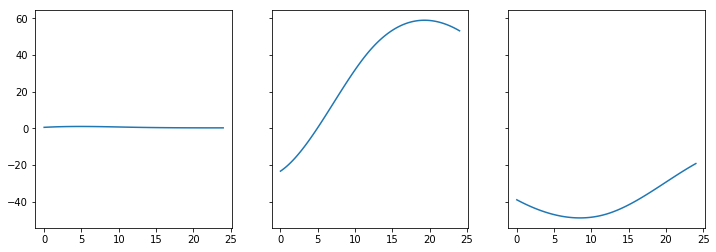

In [19]:
m = []
for i in range(n_clusters):
    m.append(LinearWithBsplinesBasis(num_basis, bsplines_degree, (low, high), no=i, init=random_basis[i]))
tr = []
tr.append( (1.0, DummyTreatment()) )
mgp = GP(m, se_cov(a=1.0, l=1.0), tr, ac_fn=None)
mgp.fit(data['training2'], init = False)
print(mgp.params)

coef = [mgp.params['linear_with_bsplines_basis_mean_coef{}'.format(no)] for no in range(len(m))]
draw_bsplines(basis, coef, len(m))

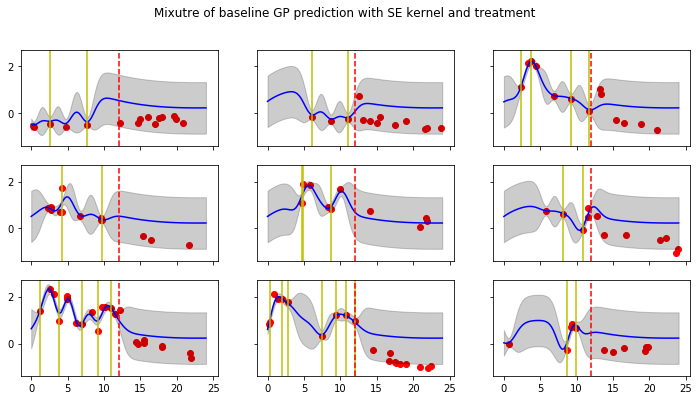

In [20]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mgp, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'])

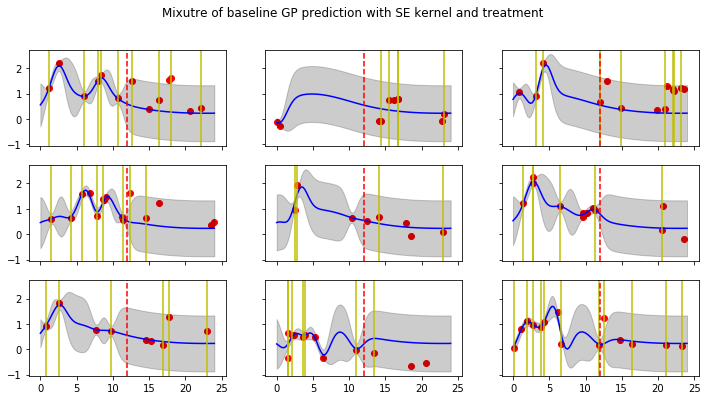

In [21]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mgp, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'], copy_truncated_rx=True)

## Mixture of BGPs with treatment

obj= 5217.310975380375
obj= 3871.6223009159285
obj= 3773.158476081762
obj= 3737.766279215493
obj= 3730.0954119192015
obj= 3728.5756873759506
obj= 3725.8408956734143
obj= 3722.8955149195795
obj= 3721.595306368568
obj= 3719.660623517969
obj= 3718.8687995398686
obj= 3717.61518033503
obj= 3716.920419221221
obj= 3715.7967885558646
obj= 3714.445744286647
obj= 3714.051056194022
obj= 3713.8815368921037
obj= 3713.766062356776
obj= 3713.6896967506073
obj= 3713.6749449101926
obj= 3713.668445025211
obj= 3713.6642655669884
obj= 3713.6609421410435
obj= 3713.6585281158386
obj= 3713.656694926321
obj= 3713.655302359144
obj= 3713.654308525834
obj= 3713.6537466268855
obj= 3713.6534545863583
obj= 3713.6531890593196
obj= 3713.65276439379
obj= 3713.6521009324356
obj= 3713.6513167744515
obj= 3713.6508940457356
obj= 3713.6505898682058
obj= 3713.6503839421007
obj= 3713.650187082251
obj= 3713.6500406215846
obj= 3713.6499696004244
obj= 3713.649927948854
obj= 3713.649871392264
obj= 3713.6497810893534
obj= 3713.64

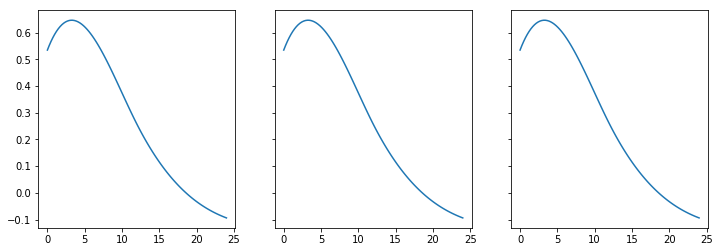

In [22]:
m = []
for i in range(n_clusters):
    m.append(LinearWithBsplinesBasis(num_basis, bsplines_degree, (low, high), no=i, init=random_basis[i]))
tr = []
tr.append( (1.0, Treatment(2.0)) )
mgp_rx = GP(m, se_cov(a=1.0, l=1.0), tr, ac_fn=None)
mgp_rx.fit(data['training2'], init = False)
print(mgp_rx.params)

coef = [mgp_rx.params['linear_with_bsplines_basis_mean_coef{}'.format(no)] for no in range(len(m))]
draw_bsplines(basis, coef, len(m))

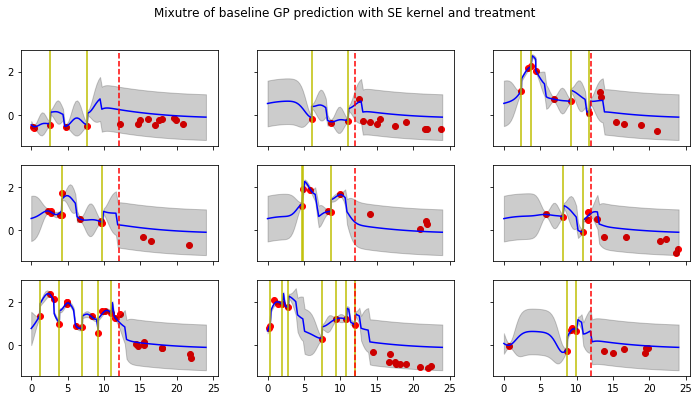

In [31]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mgp_rx, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'])

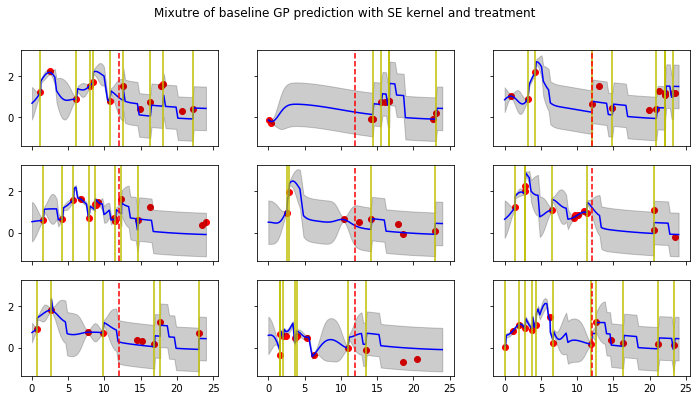

In [32]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mgp_rx, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'], copy_truncated_rx=True)

## Mixture of CGPs

obj= [8241.72162093]
obj= [7689.30111627]
obj= [7613.98994479]
obj= [7479.70379547]
obj= [7251.16675747]
obj= [7240.02887614]
obj= [7139.41271286]
obj= [7115.42027697]
obj= [7088.72195863]
obj= [7038.96414276]
obj= [6962.41385865]
obj= [6879.69020769]
obj= [6871.44281129]
obj= [6871.01697555]
obj= [6870.98212329]
obj= [6870.93528699]
obj= [6870.89895713]
obj= [6870.84413389]
obj= [6870.76144494]
obj= [6870.67496494]
obj= [6870.62847121]
obj= [6870.60876112]
obj= [6870.59458824]
obj= [6870.58351092]
obj= [6870.57808207]
obj= [6870.5760596]
obj= [6870.57496583]
obj= [6870.57420602]
obj= [6870.57381426]
obj= [6870.57365676]
obj= [6870.57357678]
obj= [6870.57352567]
obj= [6870.57349897]
obj= [6870.57348763]
obj= [6870.57348197]
obj= [6870.57347856]
obj= [6870.57347678]
obj= [6870.573476]
obj= [6870.57347561]
obj= [6870.57347539]
obj= [6870.57347527]
obj= [6870.57347522]
obj= [6870.57347519]
obj= [6870.57347518]
obj= [6870.57347517]
obj= [6870.57347517]
obj= [6870.57347516]
obj= [6870.57347

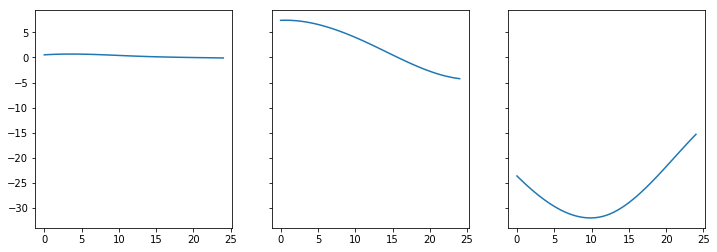

In [25]:
m = []
for i in range(n_clusters):
    m.append(LinearWithBsplinesBasis(num_basis, bsplines_degree, (low, high), no=i, init=random_basis[i]))
tr = []
tr.append( (0.0, DummyTreatment()) )
tr.append( (1.0, Treatment(2.0)) )
ac = BinaryActionModel()
mcgp = GP(m, se_cov(a=1.0, l=1.0), tr, ac_fn=ac)
mcgp.fit(data['training2'], init = False)
print(mcgp.params)

coef = [mcgp.params['linear_with_bsplines_basis_mean_coef{}'.format(no)] for no in range(len(m))]
draw_bsplines(basis, coef, len(m))

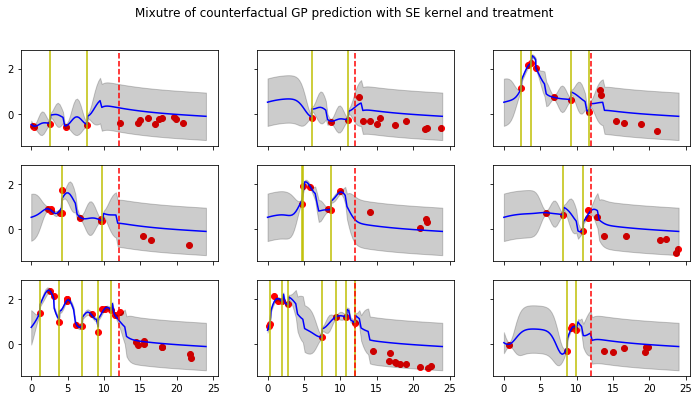

In [26]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mcgp, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of counterfactual GP prediction with SE kernel and treatment', 
             data['truncated_time'])

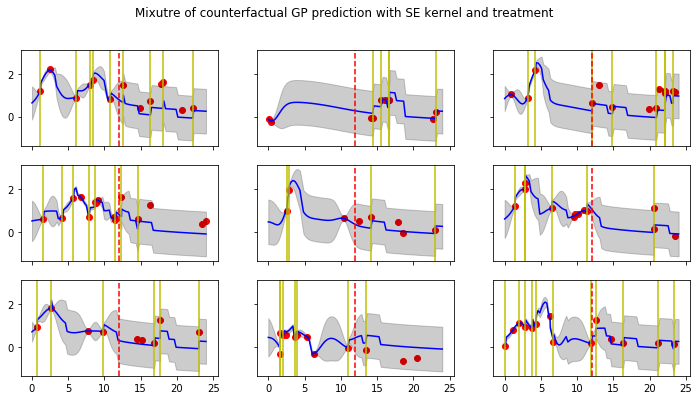

In [27]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mcgp, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of counterfactual GP prediction with SE kernel and treatment', 
             data['truncated_time'], copy_truncated_rx=True)

# MSE

In [28]:
def MSE(gp, samples, truncated_time):
    '''
    Calculate the MSE metric over points after `truncated_time`.
    '''
    s = 0.0
    for y, x in samples:
        t, rx = x
        idx = t <= truncated_time
        _y = y[idx]
        _t = t[idx]
        _rx = rx[idx]

        yhat, cov_hat = predict(gp, _y, (_t, _rx), (t, rx))
        s += np.sum((yhat[~idx] - y[~idx]) **2) / y[~idx].shape[0]
    
    return s / len(samples)

In [29]:
for s,gp in zip(['bgp', 'bgp_rx', 'cgp', 'mbgp', 'mbgp_rx', 'mcgp'], 
                 [bgp, bgp_rx, cgp, mgp, mgp_rx, mcgp]):
    print(s, MSE(gp, data['testing1'], data['truncated_time']))

bgp 0.3228047402940801
bgp_rx 0.17161638793099887
cgp 0.17912951635903324
mbgp 0.32280476326643537
mbgp_rx 0.17161638694789133
mcgp 0.17912951418240122


In [30]:
for s, gp in zip(['bgp', 'bgp_rx', 'cgp', 'mbgp', 'mbgp_rx', 'mcgp'], 
                 [bgp, bgp_rx, cgp, mgp, mgp_rx, mcgp]):
    print(s, MSE(gp, data['training2'], data['truncated_time']))

bgp 0.40099785382479475
bgp_rx 0.20507792162128607
cgp 0.24231523239629277
mbgp 0.40099785337195065
mbgp_rx 0.20507792168378572
mcgp 0.24231523136776506
